## Yelp Dataset challenge

In [1]:
# Importing classes
import re
from nltk.stem.porter import *
from nltk.stem.snowball import SnowballStemmer
import string
from py2casefold import casefold
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from scipy import sparse
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from nltk import NaiveBayesClassifier

#### Functions for parsing and stemming the dataset

In [2]:
reviews = pd.read_json('training_data.json', lines=True) # read data from jason

#function for reviewing text
def getReviewText():
    reviews_text = reviews['text']
    return reviews_text 

#function to get labels
def getLabels():
    reviews_labels = np.zeros((len(reviews['label']),1))
    for index in range(len(reviews['label'])):
        if reviews['label'][index] == 'Food-relevant':
            reviews_labels[index] = 1
    return reviews_labels

In [3]:
# function for parsing each review
def parseEachReview():
    reviews = getReviewText()
    reviews_feature = []
    for review in reviews:
        review = review.lower()
        for i in range(10):
            review = review.replace(str(i),"")
        review_word_list = re.split('[~%$\&\s,.;+\-\n\*()!?[\]@#:/"^_`{|}~<=>\']',review)
        review_word_list_stemmed = getStemmedWordList(review_word_list)
        reviews_feature.append(Counter(review_word_list_stemmed))
    return reviews_feature
    
# function for parsing whole bunch of reviews
def parseReviewText():
    reviews = getReviewText()
    reviewsStr = ' '.join(reviews)
    reviewsStr = reviewsStr.lower()
    for i in range(10):
        reviewsStr = reviewsStr.replace(str(i),"")
    reviewsStr = reviewsStr.replace("\\n", "")
    word_list = re.split('[~%$\&\s,.;+\-\n\*()!?[\]@#:/"^_`{|}~<=>\']',reviewsStr)
    return word_list

In [4]:
# Function for perforing stemming operation
def getStemmedWordList(word_list):
    stemmer = PorterStemmer(mode='NLTK_EXTENSIONS')
    stemmer2 = SnowballStemmer("english")
    stemmed_word_list = []
    for word in word_list:
        if '\\' in word:
            word = word.strip('\\')
        if word == "": 
            continue
        else:
            stemmed_word_list.append(stemmer2.stem(word))
    return stemmed_word_list

In [5]:
stemmed_word_list = getStemmedWordList(parseReviewText()) #create stemmed word list

#### Unique tokens

In [6]:
print "Unique words in list: ",len(set(stemmed_word_list))

Unique words in list:  34689


#### Zipf's Plot: - To check the distribution of words

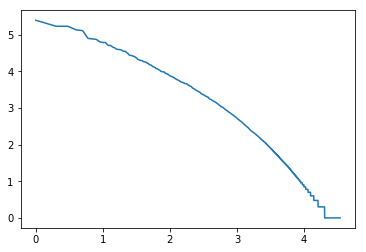

In [8]:
# your code here
%matplotlib inline 
word_frequency = Counter(stemmed_word_list)
word_frequency_sorted = sorted(word_frequency.items(), key=lambda word:word[1], reverse=True)
word_frequency_only = np.array(zip(*word_frequency_sorted)[1])
rank_log = np.log10(np.arange(1,len(word_frequency)+1, 1))
word_frequency_log = np.log10(word_frequency_only)
plt.plot(rank_log, word_frequency_log)

##### Result: - 
The plot is not consistent with the zipf's law. If we look at the list of most frequent words printed above frequency of 'i' is close to half of frequency of 'the'. But the frequency of 'and' and 'a' is not close to one third and one foruth of frequency of 'the'.

#### Creating features vector

In [9]:
# your code
reviews_labels = getLabels()      # get review labels in integer form 0 = 'Food irrelevent' and 1 = 'Food relevent'
reviews_feature = parseEachReview() # Parse each review and get the counts of words in each word

In [10]:
vec = DictVectorizer()

In [11]:
data_set = vec.fit_transform(reviews_feature) # transform the feature space to a sparse matrix

In [12]:
# spliting in test and train set
reviews_train_set,reviews_test_set, reviews_train_label,  reviews_test_label = train_test_split(data_set,
                                            reviews_labels , test_size=0.3, random_state=42)

In [13]:
naiveBayes = MultinomialNB()
naiveBayes.fit(reviews_train_set,reviews_train_label.ravel())
test_predict=naiveBayes.predict(reviews_test_set)
score_nb = metrics.accuracy_score(reviews_test_label,test_predict)
print "Accuraycy of Naive Bayes"
print("accuracy: %0.3f" % score_nb)
print(metrics.classification_report(reviews_test_label,test_predict))

Accuraycy of Naive Bayes
accuracy: 0.947
             precision    recall  f1-score   support

        0.0       0.95      0.94      0.95      5999
        1.0       0.94      0.96      0.95      6001

avg / total       0.95      0.95      0.95     12000



In [14]:
linearSVC = LinearSVC()
linearSVC.fit(reviews_train_set,reviews_train_label.ravel())
linearSVC_predict = linearSVC.predict(reviews_test_set)
score_svm = metrics.accuracy_score(reviews_test_label,linearSVC_predict)
print "Accuraycy of Linear SVM"
print("accuracy: %0.3f" % score_svm)
print(metrics.classification_report(reviews_test_label,linearSVC_predict))

Accuraycy of Linear SVM
accuracy: 0.940
             precision    recall  f1-score   support

        0.0       0.94      0.94      0.94      5999
        1.0       0.94      0.94      0.94      6001

avg / total       0.94      0.94      0.94     12000



In [15]:
tree = DecisionTreeClassifier()
tree.fit(reviews_train_set,reviews_train_label.ravel())
tree_predict = tree.predict(reviews_test_set)
score_tree = metrics.accuracy_score(reviews_test_label,tree_predict)
print "Accuraycy of Linear Decision Tree"
print("accuracy: %0.3f" % score_tree)
print(metrics.classification_report(reviews_test_label,tree_predict))

Accuraycy of Linear Decision Tree
accuracy: 0.880
             precision    recall  f1-score   support

        0.0       0.88      0.88      0.88      5999
        1.0       0.88      0.88      0.88      6001

avg / total       0.88      0.88      0.88     12000



In [16]:
mlp_classifier =  MLPClassifier(hidden_layer_sizes=(6,),alpha=1)
mlp_classifier.fit(reviews_train_set,reviews_train_label.ravel())
mlp_predict = mlp_classifier.predict(reviews_test_set)
score_mlp = metrics.accuracy_score(reviews_test_label,mlp_predict)
print "Accuraycy of MLP classifier"
print("accuracy: %0.3f" % score_mlp)
print(metrics.classification_report(reviews_test_label,mlp_predict))

Accuraycy of MLP classifier
accuracy: 0.952
             precision    recall  f1-score   support

        0.0       0.95      0.95      0.95      5999
        1.0       0.95      0.95      0.95      6001

avg / total       0.95      0.95      0.95     12000



##### Result: Multi layer perceptron won the battle.

### Using 5 fold cross-validation

In [17]:
naive_bayes_predict = cross_val_predict(MultinomialNB(), data_set, reviews_labels.ravel(), cv=5)
nb_score = metrics.accuracy_score(reviews_labels,naive_bayes_predict)
print "Accuraycy with 5 fold cross validation of Naive Bayes"
print("accuracy: %0.3f" % nb_score)
print(metrics.classification_report(reviews_labels,naive_bayes_predict))

Accuraycy with 5 fold cross validation of Naive Bayes
accuracy: 0.934
             precision    recall  f1-score   support

        0.0       0.94      0.93      0.93     20000
        1.0       0.93      0.94      0.93     20000

avg / total       0.93      0.93      0.93     40000



In [20]:
linear_svm_predict = cross_val_predict(LinearSVC(), data_set, reviews_labels.ravel(), cv=5)
linear_svm_score = metrics.accuracy_score(reviews_labels,linear_svm_predict)
print "Accuraycy with 5 fold cross validation of Linear SVM"
print("accuracy: %0.3f" % linear_svm_score)
print(metrics.classification_report(reviews_labels,linear_svm_predict))

Accuraycy with 5 fold cross validation of Linear SVM
accuracy: 0.914
             precision    recall  f1-score   support

        0.0       0.91      0.91      0.91     20000
        1.0       0.91      0.91      0.91     20000

avg / total       0.91      0.91      0.91     40000



In [21]:
decision_tree_predict = cross_val_predict(tree, data_set, reviews_labels.ravel(), cv=5)
decision_tree_score = metrics.accuracy_score(reviews_labels,decision_tree_predict)
print "Accuraycy with 5 fold cross validation of Decision tree"
print("accuracy: %0.3f" % decision_tree_score)
print(metrics.classification_report(reviews_labels,decision_tree_predict))

Accuraycy with 5 fold cross validation of Decision tree
accuracy: 0.868
             precision    recall  f1-score   support

        0.0       0.87      0.87      0.87     20000
        1.0       0.87      0.87      0.87     20000

avg / total       0.87      0.87      0.87     40000



In [22]:
mlp_predict2 = cross_val_predict(MLPClassifier(hidden_layer_sizes=(6,),alpha=1), data_set, reviews_labels.ravel(), cv=5)
mlp_score2 = metrics.accuracy_score(reviews_labels,mlp_predict2)
print "Accuraycy with 5 fold cross validation of MLP Classifier"
print("accuracy: %0.3f" % mlp_score2)
print(metrics.classification_report(reviews_labels,mlp_predict2))

Accuraycy with 5 fold cross validation of MLP Classifier
accuracy: 0.936
             precision    recall  f1-score   support

        0.0       0.93      0.95      0.94     20000
        1.0       0.95      0.93      0.94     20000

avg / total       0.94      0.94      0.94     40000



### Result: -
1. Among all the classifiers Multi layer perceptron gives the best result i.e 95.2%( for k fold ) and accuracy obtained from naive bayes is also good which is 94.7%.
2. When I apply 5 fold cross validation to different models then accuracy drops. The reason for this is cross_val_predic give prediction for each element in the input when it was in the test set.
3. Decision tree didn't perform well but with random forest 90% accuracy can be achieved by increasing max_depth.

## Improving your classifier 

In [23]:
reviews_feature2 = parseEachReview()

In [24]:
#Function for remvoing the stop word
def removeStopWords(reviews_feature_arg):
    reviews_feature_local = []
    for review in reviews_feature_arg:
        for word in stopwords.words('english'):
            if review[word] != 0:
                review[word] = 0
        reviews_feature_local.append(review)
    return reviews_feature_local
reviews_feature3 = removeStopWords(reviews_feature2) # review list after removing stop word

In [25]:
data_set2 = vec.fit_transform(reviews_feature3)
data_set2.shape

(40000, 34689)

In [37]:
reviews_train_set2,reviews_test_set2, reviews_train_label2,  reviews_test_label2 = train_test_split(data_set2,
                                            reviews_labels , test_size=0.3, random_state=42)

In [32]:
# Adding new features
stars = reviews['stars']
votes = reviews['votes']
# variables for storing the 
funny = []
useful = []
cool = []
foodCount = []
index = 0

for vote in votes:
    if reviews_labels[index] == 0:
        cool.append((vote['cool']+1) * 10)
    else:
        cool.append(vote['cool'] * 5)
    funny.append(vote['funny'])
    useful.append(vote['useful'])
    index+1
    
def countWords(reviews_feature_arg):
    three_list = []
    four_list = []
    five_list = []
    food_count = []
    food_list = ['restaur','food','order','like','servic','pizza','meal','sandwich']
    for review in reviews_feature_arg:
        three = 0
        four = 0
        five = 0
        food = 0
        for word in review.keys():
            if review[word]!=0:
                length = len(word)
                if word in food_list:
                    food = 20
                if length == 3:
                    three = three+1
                elif length == 4:
                    four = four+1
                elif length == 5:
                    five = five+1
        three_list.append(three)
        four_list.append(four)
        five_list.append(five)
        food_count.append(food)
    return three_list, four_list, five_list,food_count

three_word_count, four_word_count, five_word_count,food_word_count= countWords(reviews_feature3)

tf_transformer = TfidfTransformer(use_idf=False).fit(data_set2)
data_set_transformed = tf_transformer.transform(data_set2)
#data_set_transformed = sparse.hstack((data_set_transformed,np.array(stars)[:,None]))
#data_set_transformed = sparse.hstack((data_set_transformed,np.array(funny)[:,None]))
data_set_transformed = sparse.hstack((data_set_transformed,np.array(useful)[:,None]))
#data_set_transformed = sparse.hstack((data_set_transformed,np.array(cool)[:,None]))
#data_set_transformed = sparse.hstack((data_set_transformed,np.array(three_word_count)[:,None]))
#data_set_transformed = sparse.hstack((data_set_transformed,np.array(four_word_count)[:,None]))
data_set_transformed = sparse.hstack((data_set_transformed,np.array(five_word_count)[:,None]))
#data_set_transformed = sparse.hstack((data_set_transformed,np.array(food_word_count)[:,None]))
data_set_transformed.shape

(40000, 34691)

In [33]:
naive_bayes_predict = cross_val_predict(MultinomialNB(), data_set_transformed, reviews_labels.ravel(), cv=5)
nb_score = metrics.accuracy_score(reviews_labels,naive_bayes_predict)
print("accuracy: %0.3f" % nb_score)
print(metrics.classification_report(reviews_labels,naive_bayes_predict))

accuracy: 0.937
             precision    recall  f1-score   support

        0.0       0.94      0.93      0.94     20000
        1.0       0.93      0.94      0.94     20000

avg / total       0.94      0.94      0.94     40000



In [34]:
linearSVC = LinearSVC()
linear_svm_predict = cross_val_predict(linearSVC, data_set_transformed, reviews_labels.ravel(), cv=5)
linear_svm_score = metrics.accuracy_score(reviews_labels,linear_svm_predict)
print("accuracy: %0.3f" % linear_svm_score)
print(metrics.classification_report(reviews_labels,linear_svm_predict))

accuracy: 0.938
             precision    recall  f1-score   support

        0.0       0.93      0.95      0.94     20000
        1.0       0.95      0.93      0.94     20000

avg / total       0.94      0.94      0.94     40000



In [35]:
mlp_predict3 = cross_val_predict(MLPClassifier(hidden_layer_sizes=(6,),alpha=1), data_set_transformed, reviews_labels.ravel(), cv=5)
mlp_score3 = metrics.accuracy_score(reviews_labels,mlp_predict3)
print "Accuraycy with 5 fold cross validation of MLP Classifier"
print("accuracy: %0.3f" % mlp_score3)
print(metrics.classification_report(reviews_labels,mlp_predict3))

Accuraycy with 5 fold cross validation of MLP Classifier
accuracy: 0.925
             precision    recall  f1-score   support

        0.0       0.91      0.94      0.93     20000
        1.0       0.94      0.91      0.92     20000

avg / total       0.93      0.92      0.92     40000



#### Optimizations performed:
1. Stop words count set to zero in each review.
2. Replacing word count with tf-idf
3. Funny ratings and Fiver word count new added features

#### Result obtained
Note: I am compare results of K fold cross validation between classifiers
1. The naive bayes accuracy increased from 94.3 to 94.7
2. The SVM accuracy increased from 91.4 to 93.9
3. MLp accuracy reduced. The reason may be that it perform better on word frequency 
4. SVM wins

#### Most informative features in distinguishing these two classes

In [38]:
naiveBayes = MultinomialNB()
naiveBayes.fit(reviews_train_set2,reviews_train_label2.ravel())
class_labels = naiveBayes.classes_
feature_names = vec.get_feature_names()
topn_class1 = sorted(zip(naiveBayes.coef_[0], feature_names))[:30]
topn_class2 = sorted(zip(naiveBayes.coef_[0], feature_names))[-30:]
print "Informative features in predicting the Food-irrelevent class"
for coef, feat in topn_class1:
    print feat
print
print "Informative features in predicting the Food-relevent class"
for coef, feat in reversed(topn_class2):
    print feat

Informative features in predicting the Food-irrelevent class
a
aa
aaaaa
aaaaaa
aaaaaand
aaaaah
aaaaall
aaaaarrggggh
aaaagh
aaahhh
aaannnnndddd
aaargh
aab
aabc
aac
aaer
aaha
aanyway
aardbark
aawl
ab
abair
abasyeeja
abbi
abd
abdomen
abel
aber
abercrombi
abfertigungsschalt

Informative features in predicting the Food-relevent class
place
food
good
like
great
go
order
time
get
veri
one
servic
love
realli
back
tri
friend
would
restaur
onli
alway
chicken
even
also
best
make
littl
menu
eat
come
